# Data Preprocessing

In [16]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
dataPath = './aideeplearningproject2022/dataset/sortData/'
trianPath = './aideeplearningproject2022/train.csv'
trainLabel = pd.read_csv(trianPath, sep=',')

In [18]:
trainDataGen = ImageDataGenerator(rescale=1./255.,
                                  horizontal_flip=True,
                                #   height_shift_range=0.2,
                                #   width_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  # rotation_range=20,
                                  validation_split=0.2)
validationDataGen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

trainGenerator = trainDataGen.flow_from_directory(dataPath,
                                                  subset='training',
                                                  batch_size=32,
                                                  target_size=(96, 96),
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=10)
validationGenerator = validationDataGen.flow_from_directory(dataPath,
                                                            subset='validation',
                                                            batch_size=32,
                                                            target_size=(96, 96),
                                                            class_mode='categorical',
                                                            shuffle=True,
                                                            seed=10)


Found 664 images belonging to 16 classes.
Found 159 images belonging to 16 classes.


# Create Model and Train

In [19]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.applications import VGG16
import tensorflow as tf
import matplotlib.pyplot as plt
import absl.logging

In [20]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [21]:
def createModel(verbose=False):
    input_tensor = layers.Input(shape=(96, 96, 3))
    pretrained_model = VGG16(input_tensor=input_tensor, input_shape=(96, 96, 3), include_top=False, weights='imagenet')
    pretrained_model.trainable = False

    x = pretrained_model(input_tensor, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(units=16, activation='softmax')(x)
    
    model = models.Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()
    return model
    

In [22]:
model = createModel()
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
early_stopping = callbacks.EarlyStopping(patience=10)
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      patience=3,
                                                      factor=0.5,
                                                      min_lr=0.0001,
                                                      verbose=2)
cp = callbacks.ModelCheckpoint(filepath='./vgg16_model.ckpt', save_weight_only=True, verbose=2)
callback = [early_stopping, learning_rate_reduction, cp]


In [23]:
hist = model.fit(trainGenerator,
                 validation_data=validationGenerator,
                 callbacks=[callback],
                 epochs=100,
                 verbose=2)

Epoch 1/100

Epoch 1: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 18s - loss: 2.5483 - categorical_accuracy: 0.2123 - val_loss: 2.2236 - val_categorical_accuracy: 0.3459 - lr: 0.0010 - 18s/epoch - 869ms/step
Epoch 2/100

Epoch 2: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 18s - loss: 2.0697 - categorical_accuracy: 0.3780 - val_loss: 1.8320 - val_categorical_accuracy: 0.4277 - lr: 0.0010 - 18s/epoch - 866ms/step
Epoch 3/100

Epoch 3: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 17s - loss: 1.7073 - categorical_accuracy: 0.4473 - val_loss: 1.5765 - val_categorical_accuracy: 0.5157 - lr: 0.0010 - 17s/epoch - 822ms/step
Epoch 4/100

Epoch 4: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 1.4798 - categorical_accuracy: 0.5136 - val_loss: 1.4701 - val_categorical_accuracy: 0.5597 - lr: 0.0010 - 19s/epoch - 913ms/step
Epoch 5/100

Epoch 5: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 18s - loss: 1.3591 - categorical_accuracy: 0.5617 - val_loss: 1.4285 - val_categorical_accuracy: 0.5912 - lr: 0.0010 - 18s/epoch - 873ms/step
Epoch 6/100

Epoch 6: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 1.2565 - categorical_accuracy: 0.6386 - val_loss: 1.2992 - val_categorical_accuracy: 0.5975 - lr: 0.0010 - 19s/epoch - 924ms/step
Epoch 7/100

Epoch 7: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 1.1968 - categorical_accuracy: 0.6160 - val_loss: 1.2956 - val_categorical_accuracy: 0.5786 - lr: 0.0010 - 19s/epoch - 891ms/step
Epoch 8/100

Epoch 8: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 1.0777 - categorical_accuracy: 0.6717 - val_loss: 1.3156 - val_categorical_accuracy: 0.5723 - lr: 0.0010 - 19s/epoch - 889ms/step
Epoch 9/100

Epoch 9: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 1.0504 - categorical_accuracy: 0.6747 - val_loss: 1.2673 - val_categorical_accuracy: 0.5660 - lr: 0.0010 - 19s/epoch - 889ms/step
Epoch 10/100

Epoch 10: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 0.9693 - categorical_accuracy: 0.6958 - val_loss: 1.2160 - val_categorical_accuracy: 0.6478 - lr: 0.0010 - 19s/epoch - 913ms/step
Epoch 11/100

Epoch 11: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 0.9353 - categorical_accuracy: 0.7003 - val_loss: 1.1864 - val_categorical_accuracy: 0.6352 - lr: 0.0010 - 19s/epoch - 918ms/step
Epoch 12/100

Epoch 12: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 18s - loss: 0.8661 - categorical_accuracy: 0.7169 - val_loss: 1.2183 - val_categorical_accuracy: 0.6478 - lr: 0.0010 - 18s/epoch - 870ms/step
Epoch 13/100

Epoch 13: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 0.8080 - categorical_accuracy: 0.7440 - val_loss: 1.2060 - val_categorical_accuracy: 0.6352 - lr: 0.0010 - 19s/epoch - 892ms/step
Epoch 14/100

Epoch 14: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 0.7913 - categorical_accuracy: 0.7545 - val_loss: 1.2916 - val_categorical_accuracy: 0.6226 - lr: 0.0010 - 19s/epoch - 882ms/step
Epoch 15/100

Epoch 15: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 0.7808 - categorical_accuracy: 0.7304 - val_loss: 1.2606 - val_categorical_accuracy: 0.5849 - lr: 0.0010 - 19s/epoch - 890ms/step
Epoch 16/100

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 16: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 0.7437 - categorical_accuracy: 0.7666 - val_loss: 1.2445 - val_categorical_accuracy: 0.6226 - lr: 0.0010 - 19s/epoch - 927ms/step
Epoch 17/100

Epoch 17: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 0.6542 - categorical_accuracy: 0.7967 - val_loss: 1.1284 - val_categorical_accuracy: 0.6541 - lr: 2.0000e-04 - 19s/epoch - 882ms/step
Epoch 18/100

Epoch 18: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 17s - loss: 0.6244 - categorical_accuracy: 0.8133 - val_loss: 1.1279 - val_categorical_accuracy: 0.6604 - lr: 2.0000e-04 - 17s/epoch - 811ms/step
Epoch 19/100

Epoch 19: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 17s - loss: 0.5751 - categorical_accuracy: 0.8404 - val_loss: 1.1259 - val_categorical_accuracy: 0.6541 - lr: 2.0000e-04 - 17s/epoch - 831ms/step
Epoch 20/100

Epoch 20: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 18s - loss: 0.5869 - categorical_accuracy: 0.8283 - val_loss: 1.1343 - val_categorical_accuracy: 0.6352 - lr: 2.0000e-04 - 18s/epoch - 841ms/step
Epoch 21/100

Epoch 21: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 18s - loss: 0.5795 - categorical_accuracy: 0.8283 - val_loss: 1.1309 - val_categorical_accuracy: 0.6541 - lr: 2.0000e-04 - 18s/epoch - 836ms/step
Epoch 22/100

Epoch 22: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 20s - loss: 0.5845 - categorical_accuracy: 0.8313 - val_loss: 1.1529 - val_categorical_accuracy: 0.6541 - lr: 2.0000e-04 - 20s/epoch - 943ms/step
Epoch 23/100

Epoch 23: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 20s - loss: 0.5868 - categorical_accuracy: 0.8117 - val_loss: 1.1144 - val_categorical_accuracy: 0.6667 - lr: 2.0000e-04 - 20s/epoch - 936ms/step
Epoch 24/100

Epoch 24: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 21s - loss: 0.5654 - categorical_accuracy: 0.8208 - val_loss: 1.1294 - val_categorical_accuracy: 0.6541 - lr: 2.0000e-04 - 21s/epoch - 985ms/step
Epoch 25/100

Epoch 25: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 21s - loss: 0.5417 - categorical_accuracy: 0.8404 - val_loss: 1.1422 - val_categorical_accuracy: 0.6541 - lr: 2.0000e-04 - 21s/epoch - 987ms/step
Epoch 26/100

Epoch 26: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 20s - loss: 0.5596 - categorical_accuracy: 0.8298 - val_loss: 1.1236 - val_categorical_accuracy: 0.6541 - lr: 2.0000e-04 - 20s/epoch - 953ms/step
Epoch 27/100

Epoch 27: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 17s - loss: 0.5496 - categorical_accuracy: 0.8343 - val_loss: 1.1362 - val_categorical_accuracy: 0.6667 - lr: 2.0000e-04 - 17s/epoch - 823ms/step
Epoch 28/100

Epoch 28: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 28: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 18s - loss: 0.5238 - categorical_accuracy: 0.8389 - val_loss: 1.1516 - val_categorical_accuracy: 0.6541 - lr: 2.0000e-04 - 18s/epoch - 837ms/step
Epoch 29/100

Epoch 29: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 17s - loss: 0.5123 - categorical_accuracy: 0.8539 - val_loss: 1.1465 - val_categorical_accuracy: 0.6541 - lr: 4.0000e-05 - 17s/epoch - 814ms/step
Epoch 30/100

Epoch 30: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 18s - loss: 0.5295 - categorical_accuracy: 0.8358 - val_loss: 1.1442 - val_categorical_accuracy: 0.6541 - lr: 4.0000e-05 - 18s/epoch - 834ms/step
Epoch 31/100

Epoch 31: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 17s - loss: 0.5095 - categorical_accuracy: 0.8479 - val_loss: 1.1399 - val_categorical_accuracy: 0.6541 - lr: 4.0000e-05 - 17s/epoch - 827ms/step
Epoch 32/100

Epoch 32: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 20s - loss: 0.5139 - categorical_accuracy: 0.8449 - val_loss: 1.1385 - val_categorical_accuracy: 0.6541 - lr: 4.0000e-05 - 20s/epoch - 961ms/step
Epoch 33/100

Epoch 33: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 33: saving model to .\vgg16_model.ckpt
INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


INFO:tensorflow:Assets written to: .\vgg16_model.ckpt\assets


21/21 - 19s - loss: 0.5070 - categorical_accuracy: 0.8554 - val_loss: 1.1351 - val_categorical_accuracy: 0.6541 - lr: 4.0000e-05 - 19s/epoch - 892ms/step


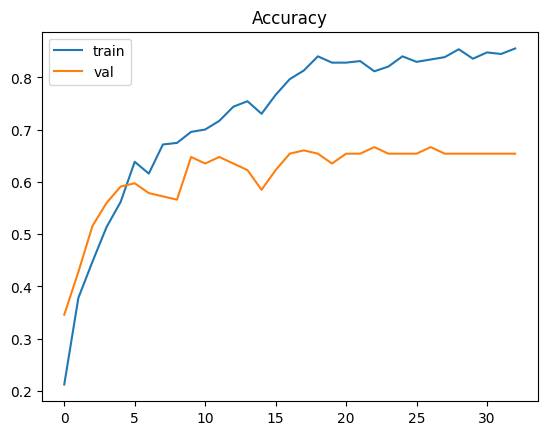

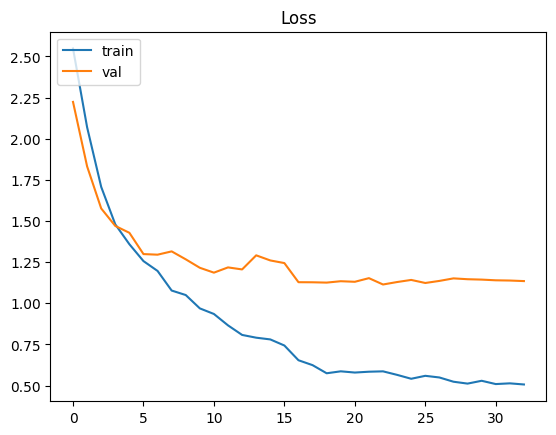

In [24]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [25]:
# input_tensor = layers.Input(shape=(128, 128, 3))
# pretrained_model = MobileNet(input_tensor=input_tensor, input_shape=(128, 128, 3), include_top=False, weights='imagenet')
# pretrained_output = pretrained_model.output

# x = layers.GlobalAveragePooling2D()(pretrained_output)
# x = layers.Dense(units=64, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# output = layers.Dense(units=16, activation='softmax')(x)

# model = models.Model(inputs=input_tensor, outputs=output)

In [26]:
# for layer in pretrained_model.layers:
#     layer.trainable = False

In [27]:
# model.compile(optimizer=optimizers.Adam(),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# hist = model.fit(trainGenerator,
#                  validation_data=validationGenerator,
#                  callbacks=[callback],
#                  epochs=50,
#                  verbose=2)

In [28]:
# for i, layer in enumerate(pretrained_model.layers):
#    print(i, layer.name)

In [29]:
model.save('catClassify_MobileNet.h5')